# See Whether Molecular Dynamics Works
We want to make sure that molecular dynamics with our new model still produces reasonable structures

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from fff.simulation import run_calculator
from fff.simulation.md import run_dynamics
from fff.learning.gc.ase import SchnetCalculator
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.calculators.psi4 import Psi4
from ase.db import connect
from tqdm import tqdm
import numpy as np
import warnings
import torch

/home/lward/miniconda3/envs/fastforce/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configure the DFT methods

In [2]:
dft_kwargs = dict(method='b3lyp-d3', basis='6-31g')

## Get a starting structure
Just a random structure to start with

In [3]:
with connect('../initial-database/initial-psi4.db') as db:
    atoms = next(db.select('', limit=1)).toatoms()
atoms

Atoms(symbols='H42O21', pbc=False, calculator=SinglePointCalculator(...))

## Make the SchNet and Psi4 Calculators
We're going to compare their performance

In [4]:
%%time
psi4_calc = Psi4(**dft_kwargs, num_threads=12)
psi4_eng = psi4_calc.get_potential_energy(atoms)

  Threads set to 12 by Python driver.
  Threads set to 12 by Python driver.


/home/lward/miniconda3/envs/fastforce/lib/python3.10/site-packages/psi4/driver/procrouting/empirical_dispersion.py:212: FutureWarning: Using the `local_options` keyword argument is deprecated in favor of using `task_config`, in version 0.30.0 it will stop working.
  jobrec = qcng.compute(


CPU times: user 6min 1s, sys: 7.27 s, total: 6min 9s
Wall time: 42.3 s


In [5]:
%%time
spk_calc = SchnetCalculator(torch.load('tuned/model', map_location='cpu'))
spk_eng = spk_calc.get_potential_energy(atoms)

CPU times: user 1.07 s, sys: 108 ms, total: 1.18 s
Wall time: 319 ms


In [6]:
print(f'Energy of starting geom - Psi4: {psi4_eng:.1f}, SchNet: {spk_eng:.1f} eV. Error: {(psi4_eng - spk_eng) * 1000:.1f} meV')

Energy of starting geom - Psi4: -43667.9, SchNet: -43667.9 eV. Error: -49.9 meV


Off by a few meV, which is pretty good

## Check whether MD with the SchNet Model produces reasonable structures
The energies don't have to be accurate, it just has to make reasonable structures

In [7]:
%%time
MaxwellBoltzmannDistribution(atoms, temperature_K=100)
traj = run_dynamics(atoms, spk_calc, timestep=0.1, steps=1000, log_interval=50)

CPU times: user 8min 29s, sys: 13 s, total: 8min 42s
Wall time: 51 s


Get the energies using Psi4

In [8]:
%%time
spk_energies = [a.get_potential_energy() for a in traj]

CPU times: user 39.6 ms, sys: 0 ns, total: 39.6 ms
Wall time: 3.56 ms


In [9]:
psi4_energies = []
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for a in tqdm(traj):
        try:
            psi4_eng = psi4_calc.get_potential_energy(a)
        except BaseException:
            psi4_eng = np.nan
        psi4_energies.append(psi4_eng)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [28:55<00:00, 82.66s/it]


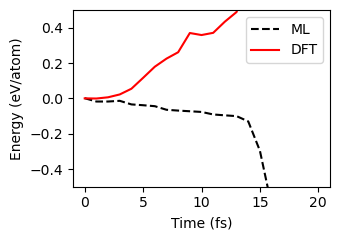

In [13]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

# Plot them normalized such that they start the same
ax.plot(np.subtract(spk_energies, psi4_energies[0]) / len(atoms), 'k--', label='ML')
ax.plot(np.subtract(psi4_energies, psi4_energies[0]) / len(atoms), 'r-', label='DFT')

ax.set_ylim(-0.5, 0.5)

ax.set_xlabel('Time (fs)')
ax.set_ylabel('Energy (eV/atom)')

ax.legend()
fig.tight_layout()

We start off with pretty similar energies, but they rapidly diverge after only a few timesteps. Molecular dynamics seemed to have found a spurious minimum! That'll be something we fix with active learning